In [3]:
import os
import sys
import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, hilbert 

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files, KNNIndex)
plt.style.use('ggplot')
path_raw = '/Users/anton/work/geolog/raw_data/2_Egor_TAR/P00_raw.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw))
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
2020,549,285,1,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,-555,286,2,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,564,284,3,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,-583,287,4,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,600,283,5,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...


In [4]:
batch = (Dataset(field_index, SeismicBatch).next_batch(500)
         .load(fmt='segy', components='raw', tslice=slice(3000))
)

In [5]:
def draw_gain(sample, window, xbounds=None, ybounds=None):
    if isinstance(sample, (tuple, list)):
        sample = np.array(sample)
    if len(sample.shape) == 1:
        sample = sample.reshape(1, -1)
    results = []
    for trace in sample:
        H = hilbert(trace).real
        env = (trace**2 + H**2)**.5
        max_val = np.max(env)
        env = (-1) * (max_val / env)
        filtered = medfilt(env, window)
        results.append(filtered)

    result = np.mean(results, axis=0)
    if xbounds is None:
        xbounds = (min(result)-min(result)*1.1, max(result)+min(result)*1.1)
    elif not isinstance(xbounds, (list, tuple, np.ndarray)) or len(xbounds) != 2:
        raise ValueError('xbounds should be list/tuple or numpy array with lenght 2, not {} with lenght {}'.format(type(xbounds), len(xbounds)))
        
    if ybounds is None:
        ybounds = (len(result)+100, -100)
    elif not isinstance(ybounds, (list, tuple, np.ndarray)) or len(ybounds) != 2:
        raise ValueError('ybounds should be list/tuple or numpy array with lenght 2, not {} with lenght {}'.format(type(xbounds), len(xbounds)))

    plt.figure(figsize=(10, 8))
    plt.plot(result, range(len(result)))
    plt.title('Amplitude gain')
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    plt.xlabel('Maxamp/Amp')
    plt.ylabel('Time')
    plt.show()



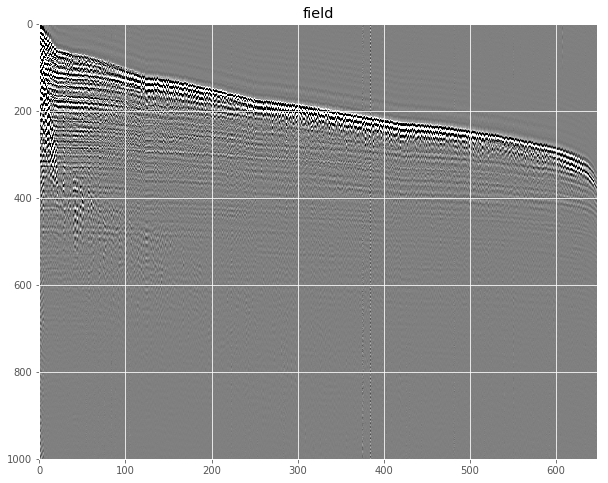

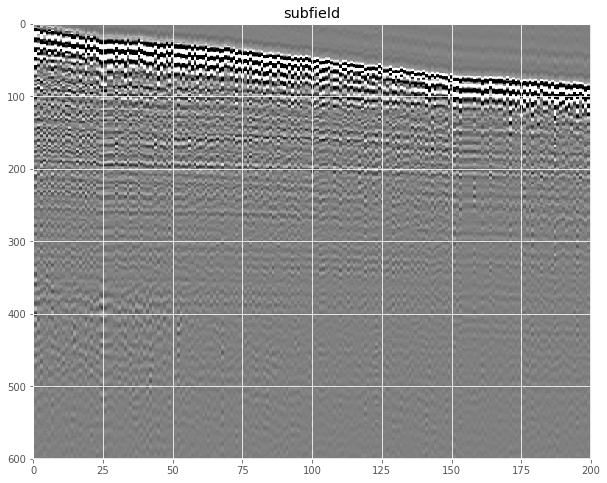

In [6]:
sample = batch.raw[21]

cv = 0.1
subsample = sample[100:300, 100:700]
seismic_plot(sample*10000, figsize=(10, 8), names='field',
             vmin=-cv, vmax=cv, cmap='gray', )
seismic_plot(subsample*10000, figsize=(10, 8), names='subfield',
             vmin=-cv, vmax=cv, cmap='gray')

### using sliding window

In [71]:
window = 250
len_sample = sample.shape[1]
amp_wanted = np.mean(sample[:, 0: window]) * 3
new_field = []
for ix_subfield in range(0, len_sample, window):
    subfield = sample[:,ix_subfield: ix_subfield+window]
    current_amp = np.mean(subfield)
    new_field.append(subfield * (amp_wanted/current_amp))

In [72]:
stack_field = np.hstack(new_field)

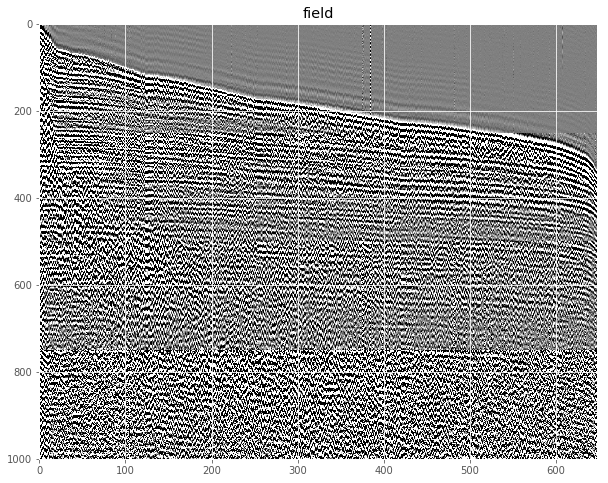

In [73]:
seismic_plot(stack_field*10000, figsize=(10, 8), names='field',
             vmin=-cv, vmax=cv, cmap='gray', )

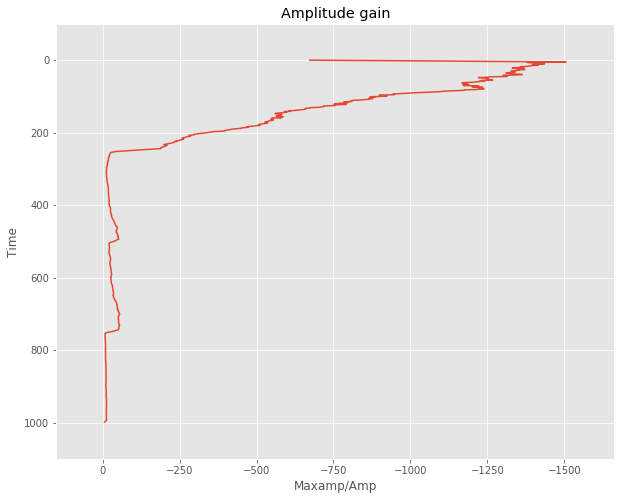

In [74]:
draw_gain(stack_field, 11)

### correction using time information

### correction using radius